# Characterising different lamina connections 

Is there a useful way to group the different connection types by the variability of their counts? 
- Fixed/invariant -> Observed in most circuits, mean counts high/var low
- Retinotopically-dependent -> High variance, but the variance of these connection counts decrease 
- Stochastic/variant/noise

We observed many of the possible 'pre->post' permutations that can be formed between each lamina subtype
1. Neurons and their synapses organize in ways that expend more resources to form connections that are necessary for function, while minimizing errors that expend limited synaptic contact area or have a negative influence on performance. 
2. Under normal circumstances, costs associated with the amount of space occupied by a system puts constrains on network architecture and synaptic connectivity. For Megaphragma, an insect that is subject to extreme evolutionary pressure for miniaturization, space constraints could play a dominant role in the design of its neural circuits. 
3. 

If a given connection (between a pre->post pair of neurons) is facilitated by many synapses, this connection is more likely to be a physiologically meaningful feature of the system compared to a different connection with fewer synapses. (the high metabolic/space cost of maintaining many synapses) 
2. If a given connection is observed throughout many reconstructions of the same circuit, this connection is more likely to be physiologically meaningful

1. Calculate (across ommatidia) correlation matrix containing an element for each pairwise correlation between each connection count
2. Sort rows and columns of correlation matrix to minimize distance between each connection type's vector of correlation coefficients
3. Present a hierachy of connection types with similar correlation vectors 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression

import sys
sys.path.extend(['.', '..'])
from cx_analysis.dataframe_tools import assemble_cxvectors
from vis.hex_lattice import hexplot
from vis.fig_tools import linear_cmap, subtype_cm

In [2]:
tp = '210615'
linkdf = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
cxdf = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_cxdf.pickle')

## Connections observed in the lamina
- When opposite pairs of short photoreceptors are combined (i.e. R1R4->L3 = R1->L3 + R4->L3), there are 13 classes of cells that participate in the lamina circuit
- The 12 subtypes can form at most 169 pre->post permutations. Of the 169 possibilities, we observed 161 of them at least once throughout the whole lamina
- 106 of the 161 connections observed (more than 65%) were found at an average rate of less than 1 synapse per ommatidia
- Connections that are entirely absent in some ommatidium (e.g. R1R4->eLMC_4) can still be strongly connected (large average synapse count despite many zeros) 

In [3]:
cxvecs = assemble_cxvectors(linkdf).astype(float)   # each ommatidium has a vector of the different connection counts
# Default args: external=True, interom connections included; excl_unknowns=True, filter cxs w unknown partner
cxs_before = cxvecs.columns  # hold on to all connection types incl. those with sub-threshold averages
nan_missing_L4s = True

if nan_missing_L4s:
    L4_cx = [c for c in cxvecs.columns if (c[-5: len(c)] == 'LMC_4')]
    cxvecs.loc[['B0', 'C1', 'D2', 'E4', 'E5', 'E6', 'E7'], L4_cx] = np.nan

display(f"Number of connections observed (all): {len(cxs_before)}")
mean_thresh = 1.0
cxvecs = cxvecs.loc[:, cxvecs.mean() >= mean_thresh]


display(f"Number of connections observed (where mean count >= {mean_thresh}): {len(cxvecs.columns)}")
display(f"Presyn subtypes: {linkdf['pre_type'].unique()}")
display(f"Postsyn subtypes: {linkdf['post_type'].unique()}")
display(f"Number of different connections: {len(cxvecs.columns)}")
cm = subtype_cm() # a dict

'Number of connections observed (all): 161'

'Number of connections observed (where mean count >= 1.0): 54'

"Presyn subtypes: ['LMC_N' 'centri' 'R2R5' 'R1R4' 'LMC_2' 'LMC_1' 'R3R6' 'R8' 'R7p' 'LMC_4']"

"Postsyn subtypes: ['LMC_1' 'LMC_2' 'R3R6' 'UNKNOWN' 'LMC_3' 'LMC_4' 'R7p' 'R2R5' 'R8' 'R7'\n 'LMC_N' 'centri' 'R1R4']"

'Number of different connections: 54'

In [4]:
c = 'LMC_2->LMC_4'
c[-5:len(c)]

'LMC_4'

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


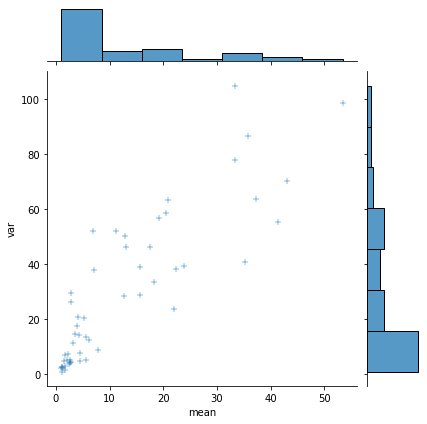

In [5]:
summary = pd.DataFrame([cxvecs.mean(), cxvecs.var(), cxvecs.std()]).T
summary = summary.rename(columns={0: 'mean', 1: 'var', 2: 'sd'})
summary = summary.rename_axis('cx')

summary['cv'] = summary['sd'] / summary['mean']
summary['ff'] = summary['var'] / summary['mean']

#fig, ax = plt.subplots()
#ax.set_title('fano')
sns.jointplot(data=summary, x='mean', y='var', marker='+')

In [6]:
display(summary.filter(axis=0, like='->eLMC').sort_values(by='cx', ascending=True))
display(summary.filter(axis=0, like='centri->'))

,mean,var,sd,cv,ff
cx,,,,,
LMC_2->eLMC_4,6.863636,51.932900,7.206449,1.049946,7.566383
R1R4->eLMC_2,2.758621,26.403941,5.138477,1.862698,9.571429
R1R4->eLMC_4,1.727273,7.064935,2.657995,1.538839,4.090226
R2R5->eLMC_4,4.045455,20.712121,4.551057,1.124980,5.119850
R3R6->eLMC_2,2.758621,29.618227,5.442263,1.972820,10.736607
R3R6->eLMC_4,2.181818,7.393939,2.719180,1.246291,3.388889


,mean,var,sd,cv,ff
cx,,,,,
centri->LMC_1,7.793103,8.884236,2.980644,0.382472,1.140013
centri->LMC_2,20.793103,63.098522,7.943458,0.382024,3.034589
centri->LMC_3,15.586207,39.036946,6.247955,0.400864,2.504583
centri->LMC_4,4.409091,7.586580,2.754375,0.624704,1.720668
centri->R1R4,1.586207,1.679803,1.296072,0.817089,1.059006
centri->R2R5,22.344828,38.233990,6.183364,0.276725,1.711089
centri->R3R6,1.206897,1.027094,1.013456,0.839721,0.851020
centri->R7,7.137931,37.980296,6.162816,0.863390,5.320911
centri->R7p,23.931034,39.423645,6.278825,0.262372,1.647386


In [7]:
from itertools import product
svfs = ['R1R4', 'R2R5', 'R3R6']
lmcs = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']
these_cx = [pre + '->' + post for pre, post in product(svfs, lmcs)]


svf_lmc = cxvecs.filter(items=these_cx)
combined_svf = pd.DataFrame()
cp_ratio = pd.DataFrame()

for l in lmcs:
    combined_svf[f'R1R4+R3R6->{l}'] = svf_lmc[f'R1R4->{l}'] + svf_lmc[f'R3R6->{l}']
    combined_svf[f'R2R5->{l}'] = svf_lmc[f'R2R5->{l}']
    cp_ratio[l] = (2.0 * combined_svf[f'R2R5->{l}'])/ combined_svf[f'R1R4+R3R6->{l}']

In [8]:
combined_svf.describe()

,R1R4+R3R6->LMC_1,R2R5->LMC_1,R1R4+R3R6->LMC_2,R2R5->LMC_2,R1R4+R3R6->LMC_3,R2R5->LMC_3,R1R4+R3R6->LMC_4,R2R5->LMC_4
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,22.000000,22.000000
mean,69.206897,35.172414,84.413793,53.448276,39.689655,37.344828,11.818182,17.590909
std,17.263461,6.397929,13.399140,9.919628,14.442258,7.987829,6.448598,6.793969
min,45.000000,23.000000,60.000000,22.000000,20.000000,23.000000,4.000000,5.000000
25%,55.000000,31.000000,75.000000,48.000000,29.000000,32.000000,7.000000,14.000000
50%,66.000000,35.000000,86.000000,56.000000,39.000000,35.000000,10.500000,18.000000
75%,82.000000,39.000000,92.000000,59.000000,46.000000,42.000000,15.750000,22.750000
max,122.000000,49.000000,123.000000,74.000000,76.000000,58.000000,32.000000,28.000000


In [9]:
cp_ratio.describe()

,LMC_1,LMC_2,LMC_3,LMC_4
count,29.000000,29.000000,29.000000,22.000000
mean,1.055894,1.287258,2.086754,3.705107
std,0.236933,0.280432,0.745626,1.914245
min,0.557377,0.578947,0.657895,0.312500
25%,0.904762,1.166667,1.695652,2.692308
50%,1.022222,1.303371,2.058824,3.437500
75%,1.207547,1.432836,2.465116,4.465909
max,1.490909,1.968750,4.100000,8.666667


/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cv', ylabel='Density'>

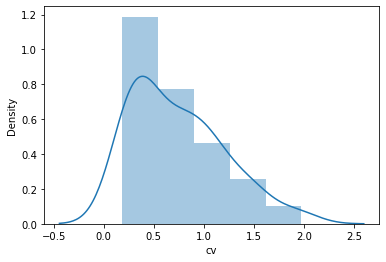

In [10]:
sns.distplot(summary['cv'])

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ff', ylabel='Density'>

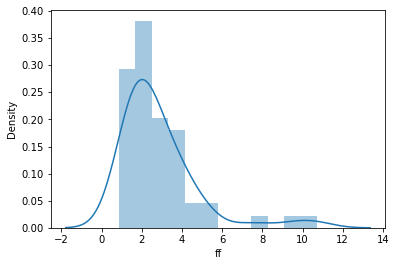

In [11]:
sns.distplot(summary['ff'])

## Clustering the correlation matrix of all connections including those between cartridges

In [12]:
# INCLUDING INTEROM CONNECTIONS

# cx_corr = cxvecs.corr().dropna(axis=1)
# display(len(cx_corr))
# row_colors = [cm[x.split('->')[0]] for x in cx_corr.index]
# col_colors = [cm[x.split('->')[1]] for x in cx_corr.columns]
# sns.clustermap(cx_corr, xticklabels=cx_corr.columns, yticklabels=cx_corr.columns, 
#                row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
#                figsize=[15, 15], metric='cosine', cmap='vlag')

## Clustering the correlation matrix of only home (intra-ommatidial) connections

48 connection types


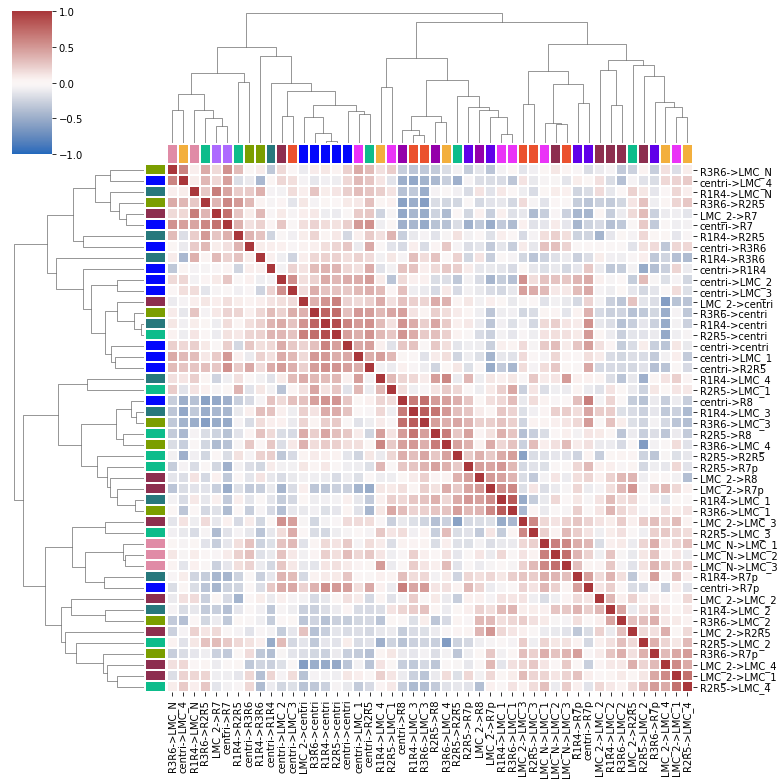

In [13]:
# EXCLUDE INTEROM CONNECTIONS

homevecs = cxvecs.loc[:, [i for i in cxvecs.columns if '->e' not in i]]
print(f"{len(homevecs.columns)} connection types")

cx_corr = homevecs.corr().dropna(axis=1)
row_colors = [cm[x.split('->')[0]] for x in cx_corr.index]
col_colors = [cm[x.split('->')[1]] for x in cx_corr.columns]
clus = sns.clustermap(cx_corr, xticklabels=cx_corr.columns, yticklabels=cx_corr.columns, 
                      row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
                      figsize=[11, 11], metric='cosine', 
                      cmap='vlag', vmax=1.0, vmin=-1.0)
#clus.savefig("/mnt/home/nchua/Dropbox/200610_ctype_clus.svg")

48 connection types


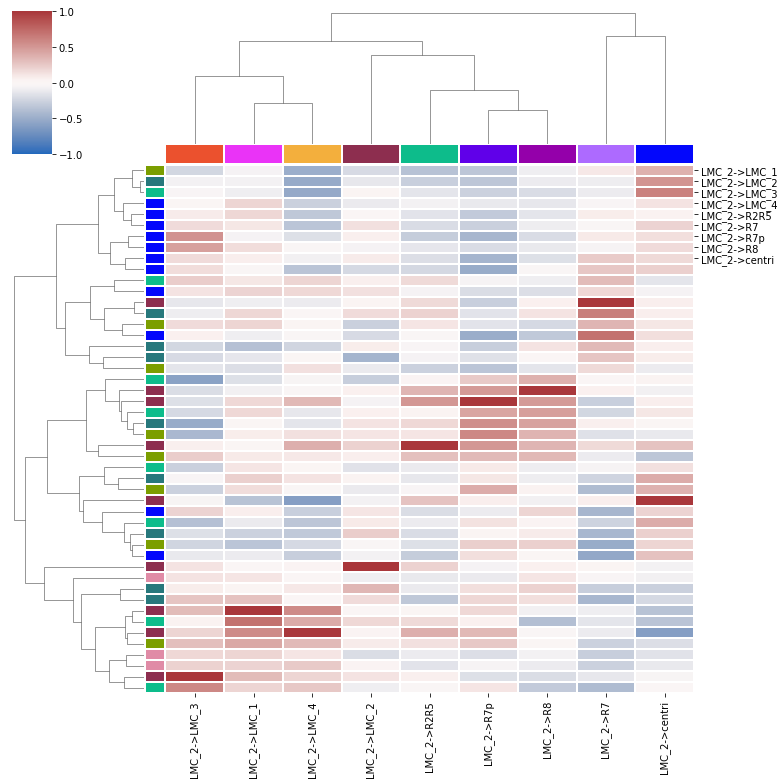

In [14]:
homevecs = cxvecs.loc[:, [i for i in cxvecs.columns if '->e' not in i]]
print(f"{len(homevecs.columns)} connection types")

cx_corr = homevecs.corr().dropna(axis=1)
cx_corr = cx_corr.filter(regex='LMC_2->')

row_colors = [cm[x.split('->')[0]] for x in cx_corr.index]
col_colors = [cm[x.split('->')[1]] for x in cx_corr.columns]
clus = sns.clustermap(cx_corr, xticklabels=cx_corr.columns, yticklabels=cx_corr.columns, 
                      row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
                      figsize=[11, 11], metric='cosine', 
                      cmap='vlag', vmax=1.0, vmin=-1.0)

Cluster 1: L2->L3, centri->(L1, L2, L3, R1-6, R7p), (L2, R1-6, centri)->centri

Cluster 2: (R1R4, R3R6)->R2R5, centri->L4, (R1R4, R3R6)->LN, (L2, centri)->R7

Cluster 3: R2R5->(L1, L2), LN->(L1, L2, L3), L2->L4, (R1-6)->L4, L2->L1

Cluster 4: *L2->R2R5*, (R2R5, centri, L2)->R8, (R1R4, R3R6)->L3, (R1R4, R3R6)->L1, R2R5->R2R5, (R2R5, L2)->R7p

Cluster 5: L2->L2, (R1R4, R3R6)->L2, R2R5->L3, (R1R4, R3R6)->R7p 


## Amacrine connections
- All inputs to am are present in the 1st cluster, only am outputs outside this are centri->L4, centri->R7, centri->R8

ValueError: The number of observations cannot be determined on an empty distance matrix.

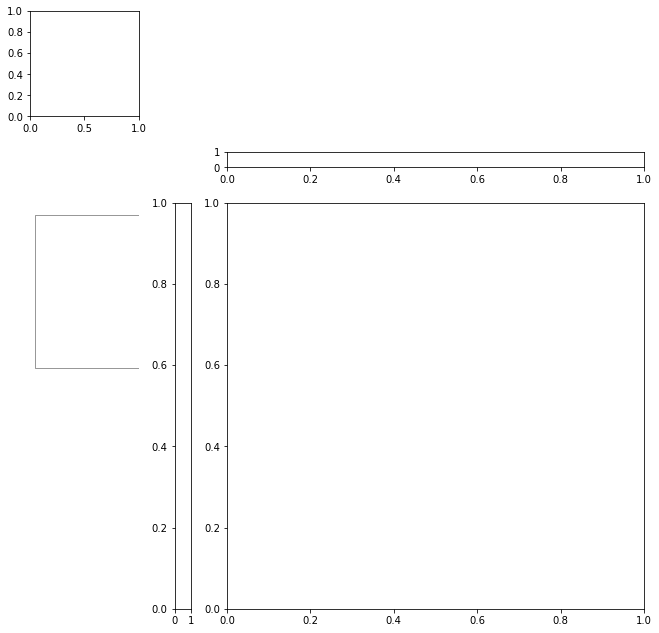

In [15]:
centri_corr = cx_corr.filter(like='centri')

row_colors = [cm[x.split('->')[0]] for x in centri_corr.index]
col_colors = [cm[x.split('->')[1]] for x in centri_corr.columns]
sns.clustermap(centri_corr, xticklabels=centri_corr.columns, yticklabels=centri_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

In [ ]:
centri_corr = cx_corr.filter(like='LMC_2->')

row_colors = [cm[x.split('->')[0]] for x in centri_corr.index]
col_colors = [cm[x.split('->')[1]] for x in centri_corr.columns]
sns.clustermap(centri_corr, xticklabels=centri_corr.columns, yticklabels=centri_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

In [ ]:
df_allom = homevecs.filter(like='->R7')
#df_allom = df_allom.loc[:, [i for i in df_allom.columns if (i[0] != 'R')]]
all_corr = df_allom.corr().dropna(axis=1)
all_corr = all_corr.loc[[i for i in df_allom.columns if (i[0] != 'R')],
                       [i for i in df_allom.columns if (i[0] != 'R')]]

row_colors = [cm[x.split('->')[0]] for x in all_corr.index]
col_colors = [cm[x.split('->')[1]] for x in all_corr.columns]
sns.clustermap(all_corr, xticklabels=all_corr.columns, yticklabels=all_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

In [ ]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
df_dra = homevecs.filter(items=dra_om, axis=0).filter(like='->R7')
#df_dra = df_dra.loc[:, [i for i in df_allom.columns if (i[0] != 'R')]]
dra_corr = df_dra.corr().dropna(axis=1)
dra_corr = dra_corr.loc[[i for i in df_allom.columns if (i[0] != 'R')], 
                        [i for i in df_allom.columns if (i[0] != 'R')]]

row_colors = [cm[x.split('->')[0]] for x in dra_corr.index]
col_colors = [cm[x.split('->')[1]] for x in dra_corr.columns]
sns.clustermap(dra_corr, xticklabels=dra_corr.columns, yticklabels=dra_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

In [ ]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [i for i in homevecs.index if i not in dra_om]
display(ndra_om)
df_dra = homevecs.filter(items=ndra_om, axis=0).filter(like='->R7')
#df_dra = df_dra.loc[:, [i for i in df_allom.columns if (i[0] != 'R')]]
dra_corr = df_dra.corr().dropna(axis=1)
dra_corr = dra_corr.loc[[i for i in df_allom.columns if (i[0] != 'R')], 
                        [i for i in df_allom.columns if (i[0] != 'R')]]

row_colors = [cm[x.split('->')[0]] for x in dra_corr.index]
col_colors = [cm[x.split('->')[1]] for x in dra_corr.columns]
sns.clustermap(dra_corr, xticklabels=dra_corr.columns, yticklabels=dra_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

In [ ]:
fig, ax = plt.subplots()
sns.regplot(x=homevecs['R1R4->R2R5'] + homevecs['R3R6->R2R5'], y=homevecs['centri->R8'], ax=ax)
ax.set_xlabel('centri -> R8')
ax.set_ylabel('R1,R3,R4,R6 -> R2,R5')

In [ ]:
fig, ax = plt.subplots()
sns.regplot(x=homevecs.filter(like='->R8').sum(axis=1), y=homevecs['R1R4->R2R5'] + homevecs['R3R6->R2R5'],
            x_jitter=0.5, y_jitter=0.5, ax=ax)
ax.set_xlabel('Inputs to R8')
ax.set_ylabel('R1, R3, R4, R6 -> R2, R5')

In [ ]:
# pairs = itertools.combinations(homevecs.columns, 2)
# for c1, c2 in pairs:
#     sns.regplot(x=homevecs[c1], y=homevecs[c2])
#     plt.show()